In [1]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [2]:
room_categories_path = "/home/cgokmen/room_categories.txt"
with open(room_categories_path) as f:
    sem_to_id = {line.strip(): i + 1 for i, line in enumerate(f.readlines())}
id_to_sem = {v: k for k, v in sem_to_id.items()}

In [3]:
# Check that all room types that show up on the list also show up on the image
import json

with open("/scr/ig_pipeline/artifacts/pipeline/combined_room_object_list.json") as f:
    room_object_lists = json.load(f)["scenes"]
scene_room_instances = {scene: list(rooms.keys()) for scene, rooms in room_object_lists.items()}
scene_room_types = {scene: {x.rsplit("_", 1)[0] for x in rooms} for scene, rooms in scene_room_instances.items()}
assert all(room in sem_to_id for rooms in scene_room_types.values() for room in rooms)

In [4]:
scene_room_types

{'Beechwood_0_garden': {'bathroom',
  'corridor',
  'dining_room',
  'garden',
  'kitchen',
  'living_room',
  'private_office',
  'storage_room',
  'utility_room'},
 'Beechwood_0_int': {'bathroom',
  'corridor',
  'dining_room',
  'kitchen',
  'living_room',
  'private_office',
  'storage_room',
  'utility_room'},
 'Beechwood_1_int': {'bathroom',
  'bedroom',
  'childs_room',
  'closet',
  'corridor',
  'playroom',
  'storage_room',
  'television_room'},
 'Benevolence_0_int': {'bathroom', 'corridor', 'empty_room', 'entryway'},
 'Benevolence_1_int': {'corridor',
  'dining_room',
  'kitchen',
  'living_room',
  'pantry_room',
  'storage_room'},
 'Benevolence_2_int': {'bathroom', 'bedroom', 'closet', 'corridor'},
 'Ihlen_0_int': {'bathroom',
  'corridor',
  'dining_room',
  'garage',
  'living_room',
  'storage_room'},
 'Ihlen_1_int': {'bathroom',
  'bedroom',
  'corridor',
  'dining_room',
  'kitchen',
  'living_room',
  'staircase',
  'storage_room'},
 'Merom_0_garden': {'bathroom',
  

In [22]:
import fs.zipfs
import fs.path
maps_fs = fs.zipfs.ZipFS("/scr/ig_pipeline/artifacts/parallels/scenes_json.zip")
valid_scenes = set(scene_room_types.keys())

In [15]:
import imagesize
import io
scene_map_sizes = {
    scene: [x * 0.01 for x in imagesize.get(io.BytesIO(maps_fs.readbytes(fs.path.join("scenes", scene, "layout", "floor_semseg_0.png"))))]
    for scene in valid_scenes
}
sorted(scene_map_sizes.items(), key=lambda x: -x[1][0] * x[1][1])

[('hall_arch_wood', [165.32, 165.32]),
 ('school_gym', [124.52, 124.52]),
 ('school_geography', [117.06, 117.06]),
 ('hall_train_station', [95.86, 95.86]),
 ('school_computer_lab_and_infirmary', [88.7, 88.7]),
 ('house_single_floor', [86.48, 86.48]),
 ('school_chemistry', [81.74, 81.74]),
 ('school_biology', [81.74, 81.74]),
 ('hall_conference_large', [74.0, 74.0]),
 ('hall_glass_ceiling', [67.84, 67.84]),
 ('Wainscott_0_garden', [64.96000000000001, 64.96000000000001]),
 ('office_large', [62.72, 62.72]),
 ('Beechwood_0_garden', [60.76, 60.76]),
 ('house_double_floor_lower', [58.88, 58.88]),
 ('office_cubicles_left', [54.68, 54.68]),
 ('hotel_gym_spa', [54.54, 54.54]),
 ('Merom_0_garden', [51.160000000000004, 51.160000000000004]),
 ('Pomaria_0_garden', [49.32, 49.32]),
 ('restaurant_hotel', [44.18, 44.18]),
 ('office_vendor_machine', [43.74, 43.74]),
 ('office_cubicles_right', [43.4, 43.4]),
 ('grocery_store_half_stocked', [37.56, 37.56]),
 ('restaurant_asian', [36.1, 36.1]),
 ('grocery

In [16]:
SKIP_SCENES = {"hall_arch_wood"}
scene_maps = {
    scene: np.array(Image.open(maps_fs.open(fs.path.join("scenes", scene, "layout", "floor_semseg_0.png"), "rb"))).astype(int)
    for scene in valid_scenes
    if scene not in SKIP_SCENES
}

/home/cgokmen/.local/share/ov/pkg/isaac_sim-2023.1.1/kit/exts/omni.kit.pip_archive/pip_prebundle/PIL/Image.py:3035: DecompressionBombWarning: Image size (155052304 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/cgokmen/.local/share/ov/pkg/isaac_sim-2023.1.1/kit/exts/omni.kit.pip_archive/pip_prebundle/PIL/Image.py:3035: DecompressionBombWarning: Image size (91891396 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/cgokmen/.local/share/ov/pkg/isaac_sim-2023.1.1/kit/exts/omni.kit.pip_archive/pip_prebundle/PIL/Image.py:3035: DecompressionBombWarning: Image size (137030436 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [23]:
valid_scenes

{'Beechwood_0_garden',
 'Beechwood_0_int',
 'Beechwood_1_int',
 'Benevolence_0_int',
 'Benevolence_1_int',
 'Benevolence_2_int',
 'Ihlen_0_int',
 'Ihlen_1_int',
 'Merom_0_garden',
 'Merom_0_int',
 'Merom_1_int',
 'Pomaria_0_garden',
 'Pomaria_0_int',
 'Pomaria_1_int',
 'Pomaria_2_int',
 'Rs_garden',
 'Rs_int',
 'Wainscott_0_garden',
 'Wainscott_0_int',
 'Wainscott_1_int',
 'grocery_store_asian',
 'grocery_store_cafe',
 'grocery_store_convenience',
 'grocery_store_half_stocked',
 'hall_arch_wood',
 'hall_conference_large',
 'hall_glass_ceiling',
 'hall_train_station',
 'hotel_gym_spa',
 'hotel_suite_large',
 'hotel_suite_small',
 'house_double_floor_lower',
 'house_double_floor_upper',
 'house_single_floor',
 'office_bike',
 'office_cubicles_left',
 'office_cubicles_right',
 'office_large',
 'office_vendor_machine',
 'restaurant_asian',
 'restaurant_brunch',
 'restaurant_cafeteria',
 'restaurant_diner',
 'restaurant_hotel',
 'restaurant_urban',
 'school_biology',
 'school_chemistry',
 '

In [24]:
room_ids_in_map = {scene: set(np.unique(img)) - {0} for scene, img in scene_maps.items()}
room_types_in_map = {scene: {id_to_sem[x] for x in room_ids} for scene, room_ids in room_ids_in_map.items()}

In [26]:
for scene in valid_scenes - SKIP_SCENES:
    expected = scene_room_types[scene]
    found = room_types_in_map[scene]
    if expected != found:
        print("Problem in", scene)
        print("Expected", expected)
        print("Found", found)
        print("Missing", expected - found)
        print("Unexpected", found - expected)
        print()

Problem in Benevolence_0_int
Expected {'corridor', 'entryway', 'empty_room', 'bathroom'}
Found {'corridor', 'empty_room', 'bathroom'}
Missing {'entryway'}
Unexpected set()

Problem in school_gym
Expected {'bathroom', 'gym', 'classroom', 'locker_room', 'corridor'}
Found {'locker_room', 'corridor', 'gym', 'bathroom'}
Missing {'classroom'}
Unexpected set()

Problem in hall_glass_ceiling
Expected {'bathroom', 'empty_room', 'corridor'}
Found {'empty_room', 'bathroom'}
Missing {'corridor'}
Unexpected set()

Problem in Beechwood_0_garden
Expected {'kitchen', 'bathroom', 'storage_room', 'private_office', 'corridor', 'living_room', 'garden', 'dining_room', 'utility_room'}
Found {'kitchen', 'bathroom', 'storage_room', 'private_office', 'living_room', 'corridor', 'dining_room', 'utility_room'}
Missing {'garden'}
Unexpected set()

Problem in Wainscott_1_int
Expected {'bedroom', 'playroom', 'bathroom', 'storage_room', 'private_office', 'closet', 'exercise_room', 'corridor', 'utility_room'}
Found {'

/home/cgokmen/.local/share/ov/pkg/isaac_sim-2023.1.1/kit/exts/omni.kit.pip_archive/pip_prebundle/PIL/Image.py:3035: DecompressionBombWarning: Image size (155052304 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/cgokmen/.local/share/ov/pkg/isaac_sim-2023.1.1/kit/exts/omni.kit.pip_archive/pip_prebundle/PIL/Image.py:3035: DecompressionBombWarning: Image size (91891396 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/cgokmen/.local/share/ov/pkg/isaac_sim-2023.1.1/kit/exts/omni.kit.pip_archive/pip_prebundle/PIL/Image.py:3035: DecompressionBombWarning: Image size (137030436 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


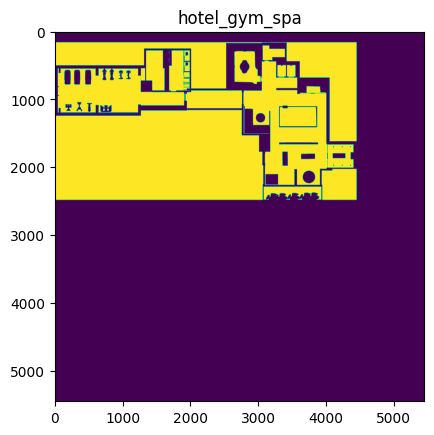

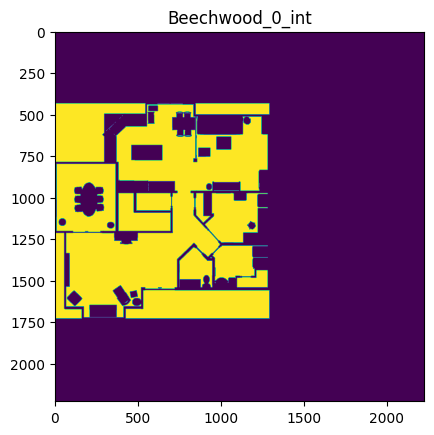

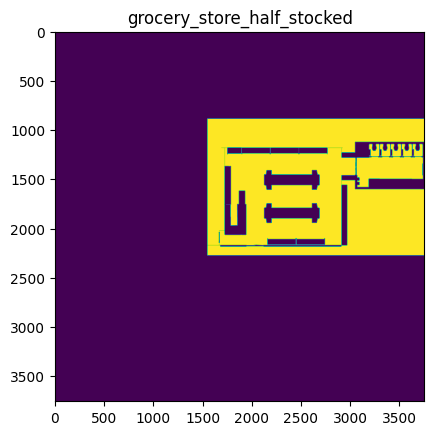

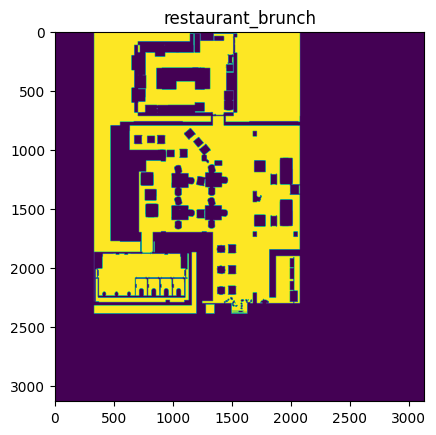

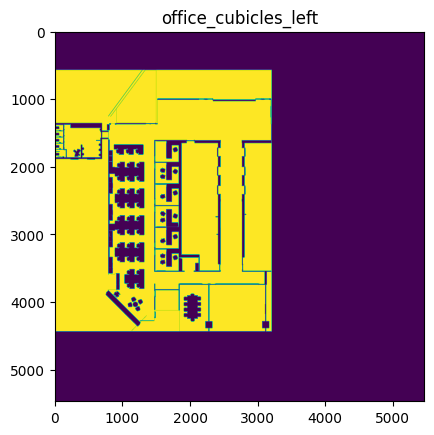

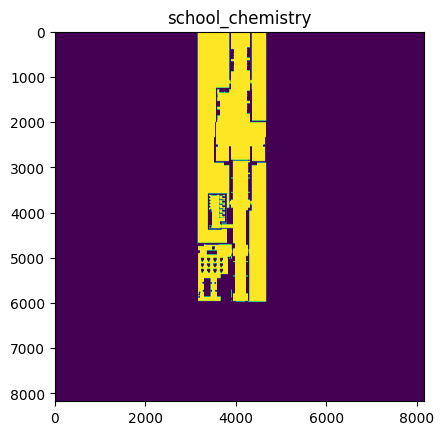

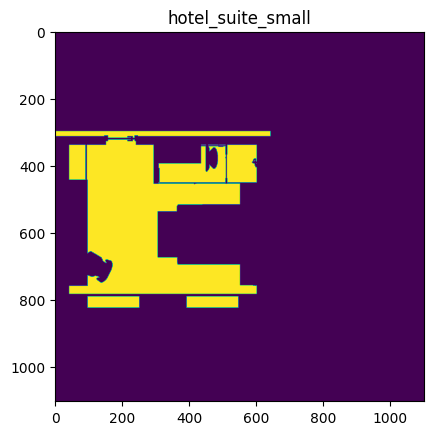

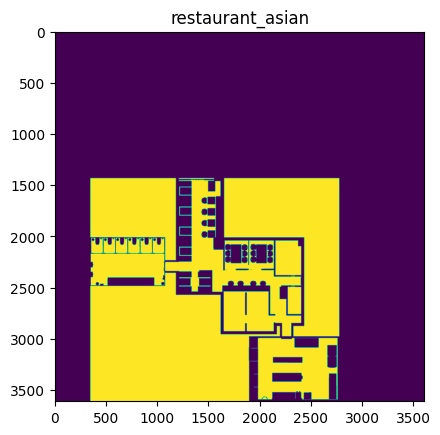

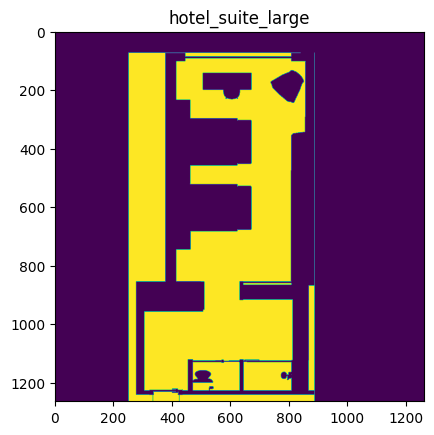

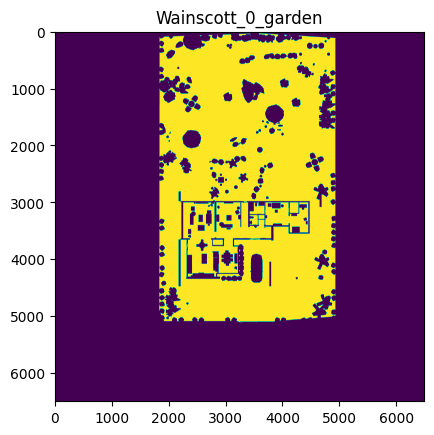

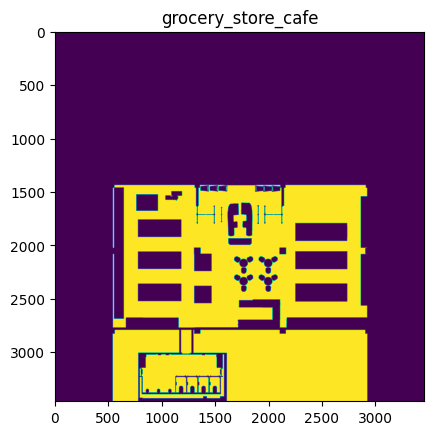

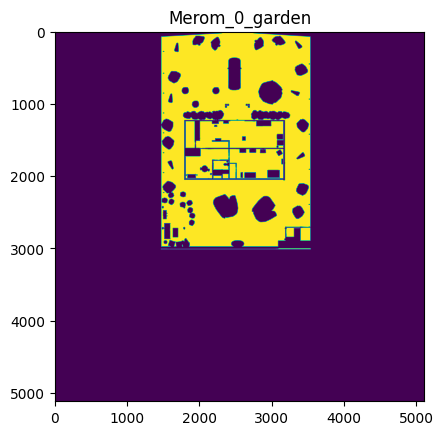

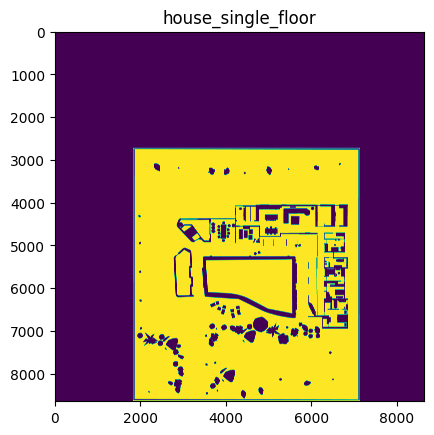

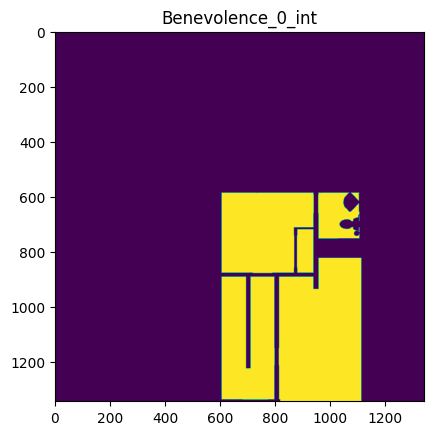

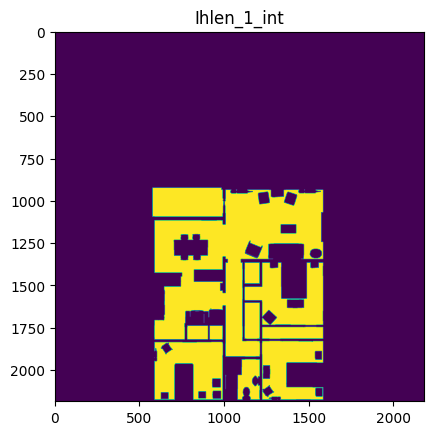

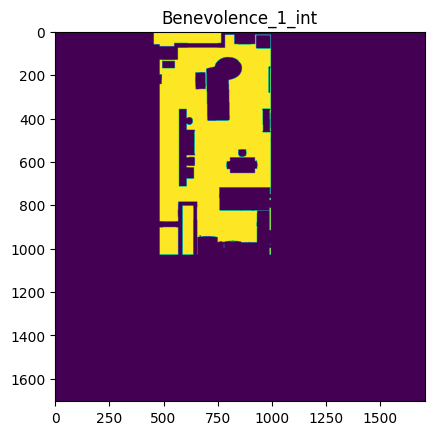

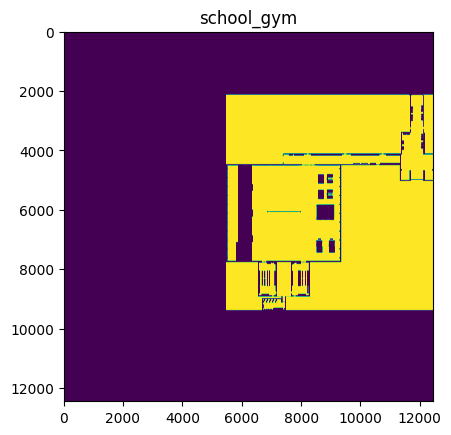

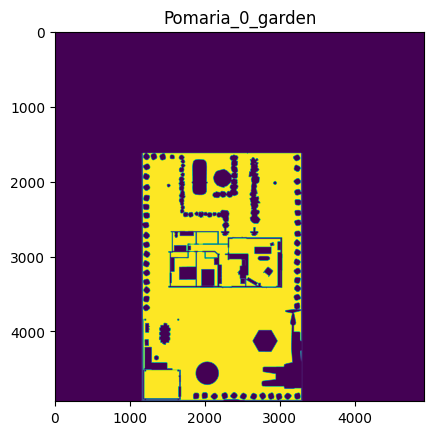

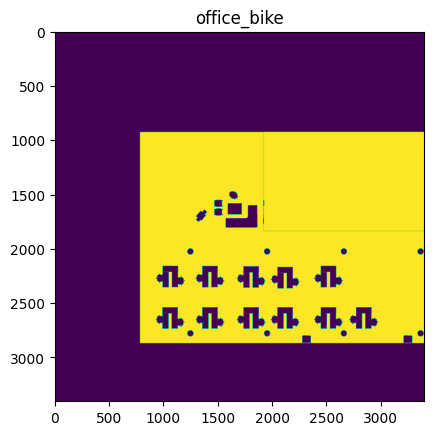

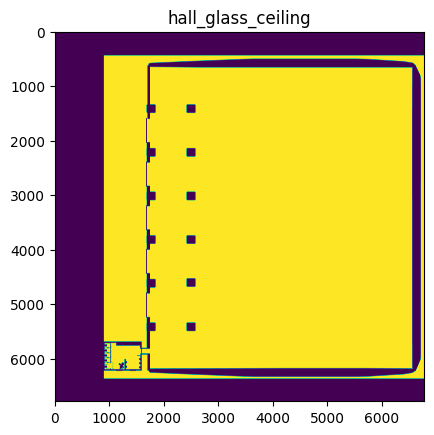

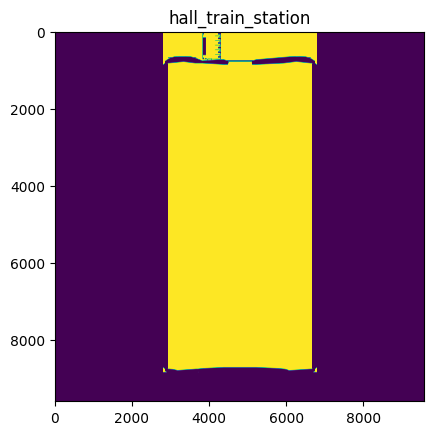

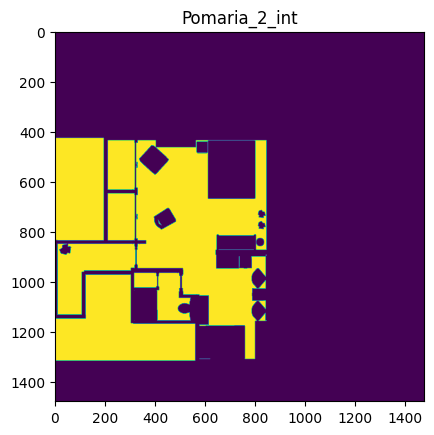

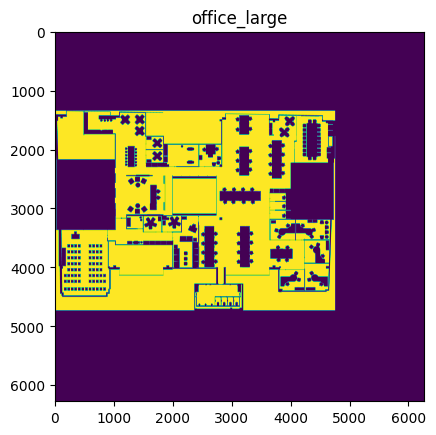

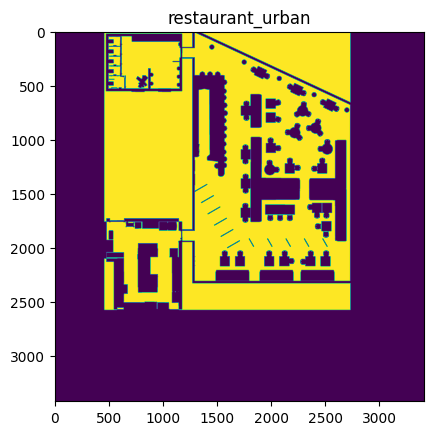

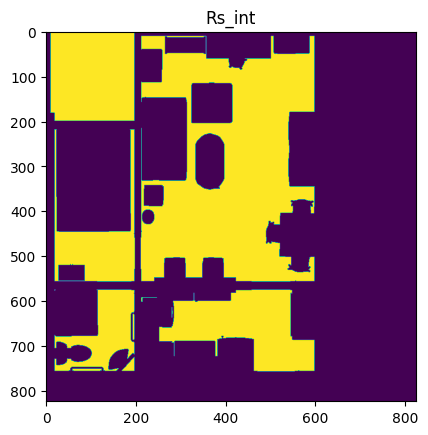

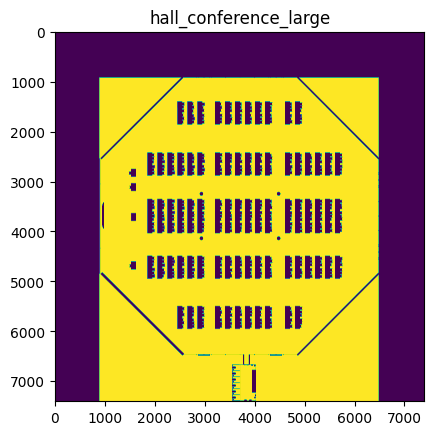

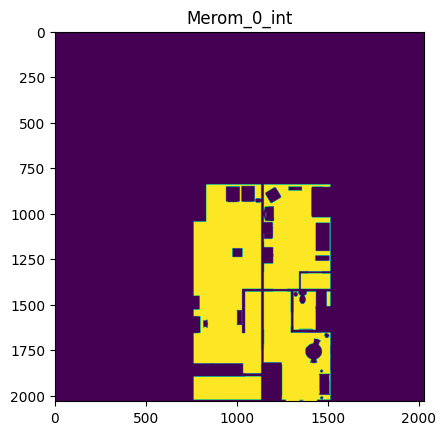

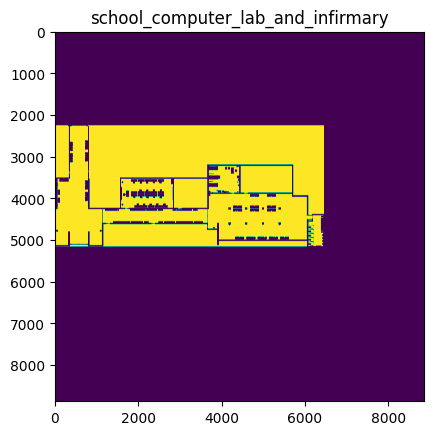

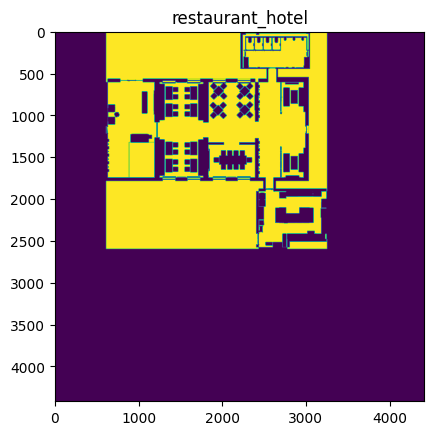

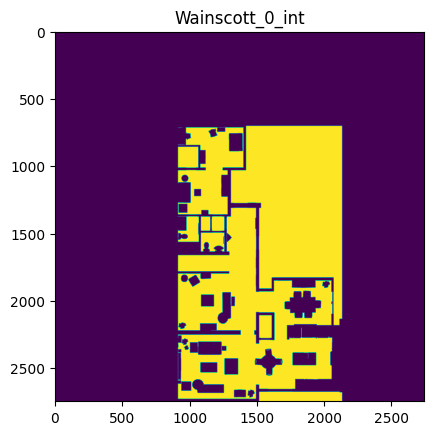

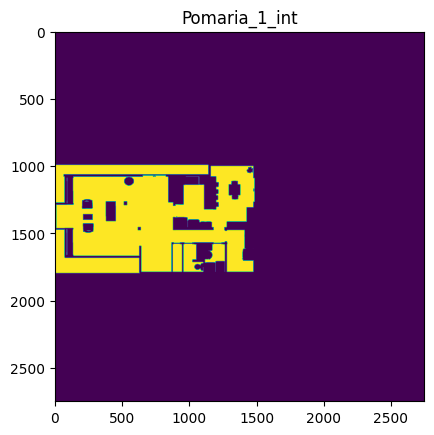

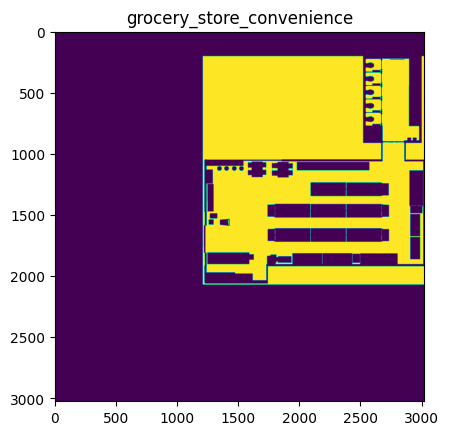

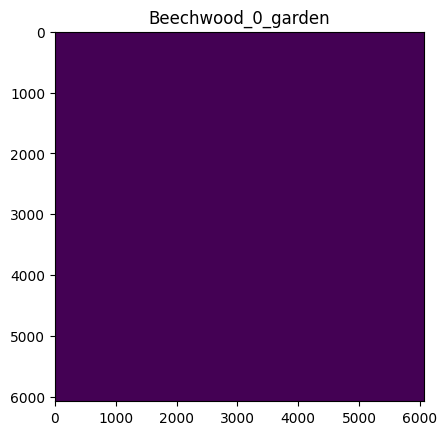

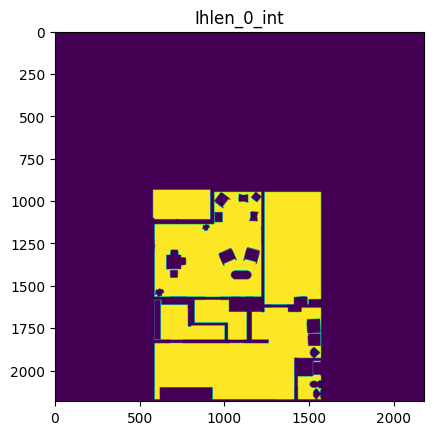

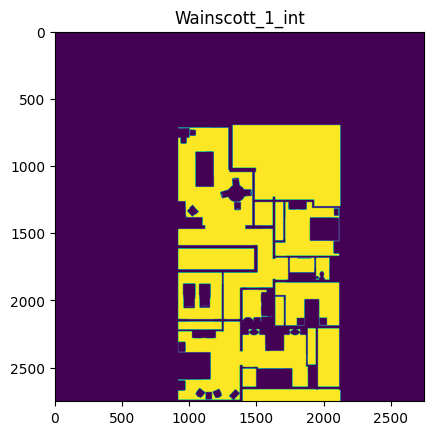

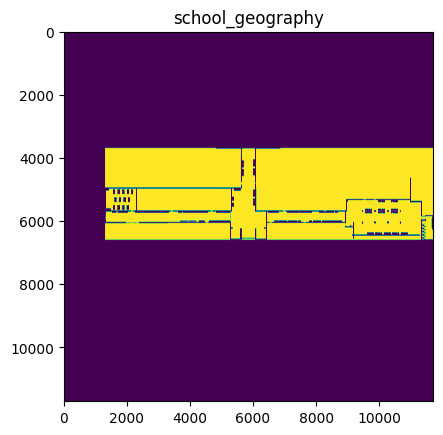

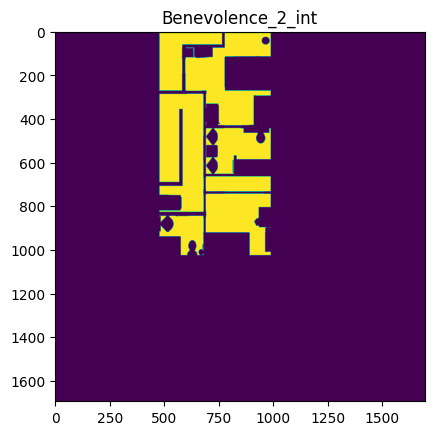

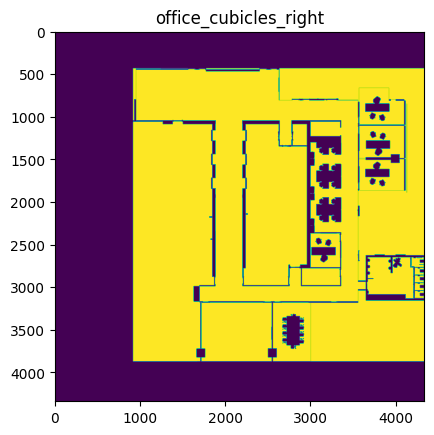

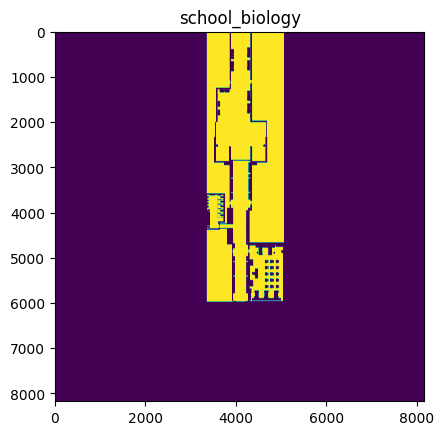

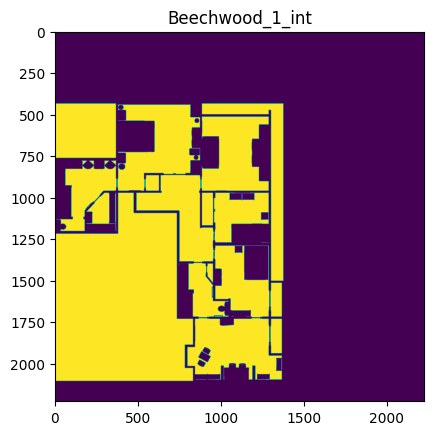

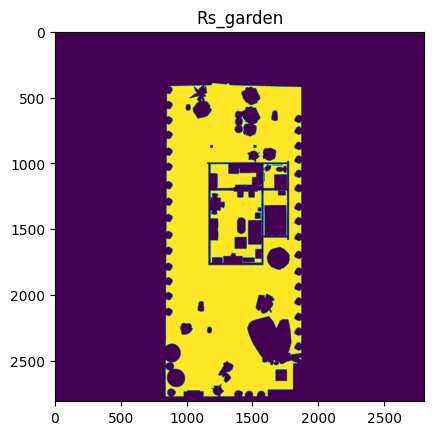

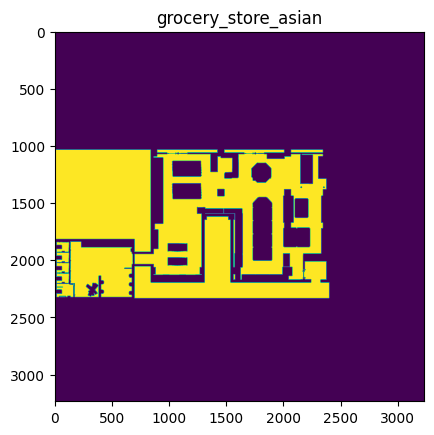

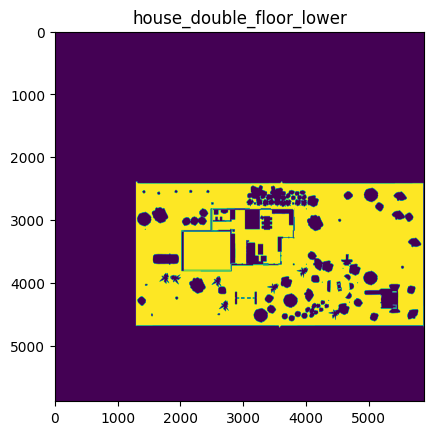

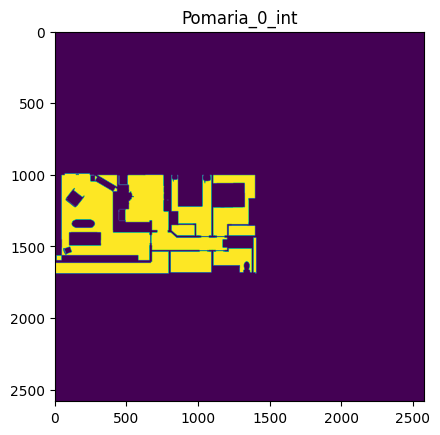

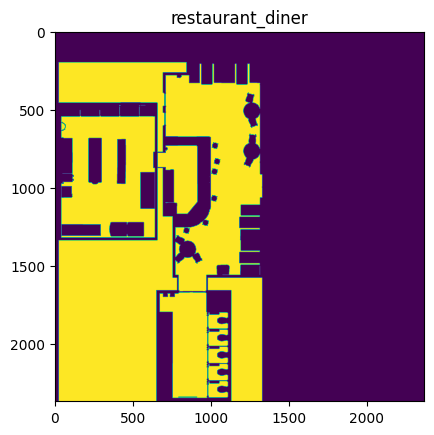

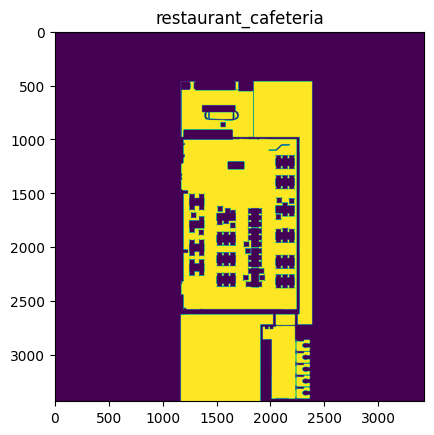

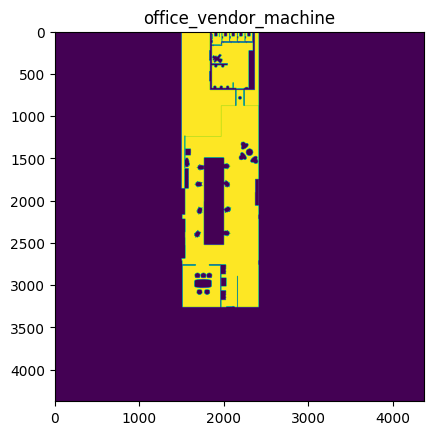

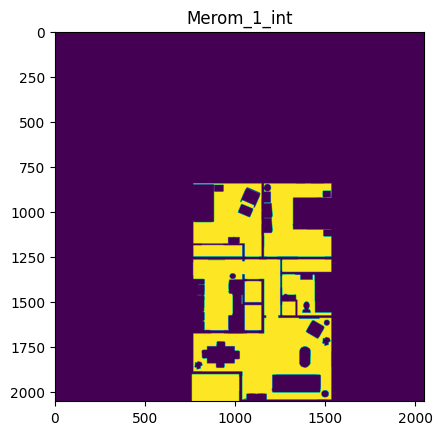

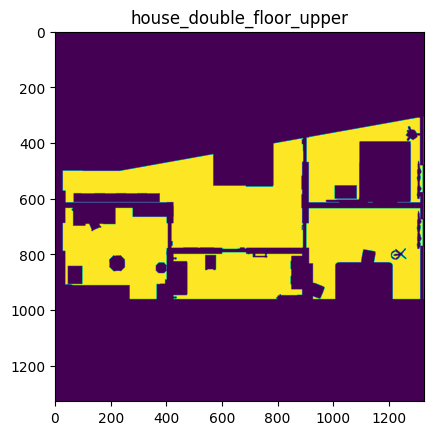

In [27]:
import matplotlib.pyplot as plt
trav_maps = {
    scene: np.array(Image.open(maps_fs.open(fs.path.join("scenes", scene, "layout", "floor_trav_0.png"), "rb"))).astype(int)
    for scene in valid_scenes
    if scene not in SKIP_SCENES
}
for scene, map_img in trav_maps.items():
    plt.imshow(map_img)
    plt.title(scene)
    plt.show()